In [57]:
import pandas as pd
import torch
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [59]:
df_labeled = pd.read_csv('C:/Users/Devanand J/Desktop/Final/Subset2000/Restaurants_Train2021.csv')
texts = df_labeled['comments'].tolist()
aspect_terms = df_labeled['aspectTerms'].tolist()


print(f"Sample texts: {texts[:3]}")
print(f"Sample aspect_terms: {aspect_terms[:3]}")



Sample texts: ['But the staff was so horrible to us.', "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.", "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not."]
Sample aspect_terms: ["[{'term': 'staff', 'polarity': 'negative'}]", "[{'term': 'food', 'polarity': 'positive'}]", "[{'term': 'food', 'polarity': 'positive'}, {'term': 'kitchen', 'polarity': 'positive'}, {'term': 'menu', 'polarity': 'neutral'}]"]


In [60]:
# Initializing tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

label_map = {
    'O': 0,
    'B-POS': 1,
    'I-POS': 2,
    'B-NEG': 3,
    'I-NEG': 4,
    'B-NEU': 5,
    'I-NEU': 6
}

def encode_labels_with_offsets(texts, aspect_info_list):
    all_labels = []
    for i, text in enumerate(texts):
        encoded_dict = tokenizer.encode_plus(
            text,
            return_offsets_mapping=True,
            truncation=True,
            padding='max_length',
            max_length=86,  
            return_tensors='pt'
        )
        
        input_ids = encoded_dict['input_ids'][0]
        offsets = encoded_dict['offset_mapping'][0]
        labels = ['O'] * len(input_ids)
        
        aspect_info = eval(aspect_info_list[i])
        
        for aspect in aspect_info:
            aspect_term = aspect['term']
            aspect_polarity = aspect['polarity']
            aspect_start = text.find(aspect_term)
            aspect_end = aspect_start + len(aspect_term)
            
            for j, (start, end) in enumerate(offsets):
                if start >= aspect_start and end <= aspect_end:
                    polarity_tag = 'POS' if aspect_polarity == 'positive' else 'NEG' if aspect_polarity == 'negative' else 'NEU'
                    if start == aspect_start:
                        labels[j] = f'B-{polarity_tag}'
                    else:
                        labels[j] = f'I-{polarity_tag}'
        
        all_labels.append([label_map[label] for label in labels])
    return all_labels

# Encoding the labels and tokenizing texts
labels = encode_labels_with_offsets(texts, aspect_terms)
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Ensure all labels are the same length as input_ids
max_len = inputs['input_ids'].shape[1]
labels = [label + [0]*(max_len - len(label)) for label in labels]

#Printing the first few tokenized texts and their labels
for i in range(3):
    print(f"Text {i}: {texts[i]}")
    print(f"Tokenized Text {i}: {tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])}")
    print(f"Labels {i}: {labels[i]}")

print(f"Input IDs Shape: {inputs['input_ids'].shape}")
print(f"Labels Shape: {len(labels)}, {len(labels[0])}")


C:\Users\Devanand J\anaconda3\envs\gpt_cuda118\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Text 0: But the staff was so horrible to us.
Tokenized Text 0: ['<s>', 'But', 'Ġthe', 'Ġstaff', 'Ġwas', 'Ġso', 'Ġhorrible', 'Ġto', 'Ġus', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Labels 0: [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [61]:
from sklearn.model_selection import train_test_split

input_ids_train, input_ids_val, attention_mask_train, attention_mask_val, labels_train, labels_val = train_test_split(
    inputs['input_ids'], inputs['attention_mask'], labels, test_size=0.1, random_state=42)

print(f"Train Input IDs Shape: {input_ids_train.shape}")
print(f"Validation Input IDs Shape: {input_ids_val.shape}")
print(f"Train Labels Shape: {len(labels_train)}, {len(labels_train[0])}")
print(f"Validation Labels Shape: {len(labels_val)}, {len(labels_val[0])}")


Train Input IDs Shape: torch.Size([1818, 86])
Validation Input IDs Shape: torch.Size([203, 86])
Train Labels Shape: 1818, 86
Validation Labels Shape: 203, 86


In [62]:
#Creating Dataset and DataLoader
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

    def __len__(self):
        return len(self.labels)

def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_masks = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels
    }

train_dataset = TextDataset(input_ids_train, attention_mask_train, labels_train)
val_dataset = TextDataset(input_ids_val, attention_mask_val, labels_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


print(f"Train DataLoader Size: {len(train_loader)}")
print(f"Validation DataLoader Size: {len(val_loader)}")


Train DataLoader Size: 228
Validation DataLoader Size: 26


In [63]:

for batch in train_loader:
    inputs = {key: val.to(device) for key, val in batch.items()}
    print(f"Input IDs Shape: {inputs['input_ids'].shape}")
    print(f"Labels Shape: {inputs['labels'].shape}")
    break


Input IDs Shape: torch.Size([8, 86])
Labels Shape: torch.Size([8, 86])


In [64]:
#Initializing Model and Optimizer
from transformers import RobertaForTokenClassification, AdamW

num_labels = len(label_map)  # O, B-POS, I-POS, B-NEG, I-NEG, B-NEU, I-NEU
model = RobertaForTokenClassification.from_pretrained('roberta-base', num_labels=num_labels)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Devanand J\anaconda3\envs\gpt_cuda118\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
# Training 
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        inputs = {key: val.to(device) for key, val in batch.items()}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []
    for batch in val_loader:
        with torch.no_grad():
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            val_loss += outputs.loss.item()
            logits = outputs.logits
            predictions.extend(logits.argmax(dim=-1).cpu().numpy())
            true_labels.extend(inputs['labels'].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")

    # Flatten true labels and predictions for evaluation
    true_labels_flat = [label for sublist in true_labels for label in sublist]
    pred_labels_flat = [pred for sublist in predictions for pred in sublist]

    accuracy = accuracy_score(true_labels_flat, pred_labels_flat)
    precision = precision_score(true_labels_flat, pred_labels_flat, average='macro')
    recall = recall_score(true_labels_flat, pred_labels_flat, average='macro')
    f1 = f1_score(true_labels_flat, pred_labels_flat, average='macro')

    print(f"Validation Accuracy: {accuracy}")
    print(f"Validation Precision: {precision}")
    print(f"Validation Recall: {recall}")
    print(f"Validation F1 Score: {f1}")


100%|██████████| 228/228 [01:12<00:00,  3.15it/s]


Epoch 1, Average Training Loss: 0.29598154310594527


C:\Users\Devanand J\anaconda3\envs\gpt_cuda118\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Validation Loss: 0.15019741869316652
Validation Accuracy: 0.958299919807538
Validation Precision: 0.32416442027869125
Validation Recall: 0.37297570305714756
Validation F1 Score: 0.3456396441008063


100%|██████████| 228/228 [01:11<00:00,  3.18it/s]


Epoch 2, Average Training Loss: 0.1643337031434241


C:\Users\Devanand J\anaconda3\envs\gpt_cuda118\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Validation Loss: 0.1307322155111111
Validation Accuracy: 0.9465001718409898
Validation Precision: 0.3249057037822078
Validation Recall: 0.3620175126959416
Validation F1 Score: 0.3399764162783792


100%|██████████| 228/228 [01:11<00:00,  3.18it/s]


Epoch 3, Average Training Loss: 0.12663272470072434
Epoch 3, Validation Loss: 0.1465809830965904
Validation Accuracy: 0.9352732271737885
Validation Precision: 0.4081582725408645
Validation Recall: 0.3907110688527213
Validation F1 Score: 0.3642889531997326


C:\Users\Devanand J\anaconda3\envs\gpt_cuda118\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
#Applying the Model to Unlabeled Data

df_unlabeled = pd.read_csv('C:/Users/Devanand J/Desktop/Final/Yelp_dataset.csv')
unlabeled_texts = df_unlabeled['preprocessed_comments'].tolist()

unlabeled_inputs = tokenizer(unlabeled_texts, padding=True, truncation=True, return_tensors="pt")

unlabeled_loader = DataLoader(TextDataset(unlabeled_inputs['input_ids'], unlabeled_inputs['attention_mask'], [0]*len(unlabeled_texts)), batch_size=16, shuffle=False, collate_fn=collate_fn)

def predict(model, dataloader):
    model.eval()
    predictions = []
    for batch in tqdm(dataloader):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=-1).cpu().numpy())
    return predictions

predictions = predict(model, unlabeled_loader)

# predictions
print(f"Sample Predictions: {predictions[:3]}")



100%|██████████| 125/125 [07:50<00:00,  3.77s/it]

Sample Predictions: [array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 5, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0,

In [40]:
#Decode Predictions
def decode_predictions(predictions, tokenizer, labels_map):
    decoded_predictions = []
    for prediction in predictions:
        labels = [labels_map[label] for label in prediction]
        decoded_predictions.append(labels)
    return decoded_predictions

labels_map = {0: 'O', 1: 'B-POS', 2: 'I-POS', 3: 'B-NEG', 4: 'I-NEG', 5: 'B-NEU', 6: 'I-NEU'}
decoded_predictions = decode_predictions(predictions, tokenizer, labels_map)

#Print the first few decoded predictions
print(f"Sample Decoded Predictions: {decoded_predictions[:3]}")


Sample Decoded Predictions: [['O', 'O', 'B-POS', 'O', 'B-POS', 'O', 'B-POS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-POS', 'O', 'O', 'I-POS', 'O', 'O', 'O', 'B-POS', 'O', 'B-POS', 'O', 'O', 'O', 'B-NEU', 'O', 'B-POS', 'I-POS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NEU', 'I-POS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NEU', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [45]:
#Extracting Aspect Terms
def extract_aspects(tokens, labels):
    aspects = []
    current_aspect = []
    current_label = None
    for token, label in zip(tokens, labels):
        if label.startswith('B-'):
            if current_aspect:
                aspects.append((' '.join(current_aspect), current_label))
            current_aspect = [token]
            current_label = label.split('-')[1]
        elif label.startswith('I-') and current_aspect:
            current_aspect.append(token)
        else:
            if current_aspect:
                aspects.append((' '.join(current_aspect), current_label))
                current_aspect = []
                current_label = None
    if current_aspect:
        aspects.append((' '.join(current_aspect), current_label))
    return aspects

# Processing each prediction to extract aspect terms and their polarities
processed_predictions = []
for i, text in enumerate(unlabeled_texts):
    tokens = tokenizer.tokenize(text)
    labels = decoded_predictions[i][:len(tokens)]  # Trim to the original length before padding
    aspects = extract_aspects(tokens, labels)
    processed_predictions.append(aspects)

# printing predictions
for i in range(3):
    print(f"Text {i}: {unlabeled_texts[i]}")
    print(f"Processed Predictions {i}: {processed_predictions[i]}")



Text 0: great food fun atmosphere amazing staff nnfood i have never had a bad mealnatmosphere fun decor clean environmentnstaff good at the door amazing wait staff nnthe only thing i would like to change is the wait time everyone wants to eat there so makes the wait long they need to open another location
Processed Predictions 0: [('Ġfun', 'POS'), ('Ġamazing', 'POS'), ('Ġn', 'POS'), ('nat', 'POS'), ('n', 'POS'), ('Ġgood', 'POS'), ('Ġamazing', 'NEU'), ('Ġstaff Ġn', 'POS'), ('Ġtime Ġeveryone', 'NEU'), ('Ġlong', 'NEU')]
Text 1: this is some kick ass mexican food done right visiting from california we heard that this was a great new place we were not disappointed everything we ordered was fantastic we ordered one of each taco each done a different way my favorite was the chicken with pinon cream the corn appetizer and guacamole are must order items the pozole verdewow better than mine and mine is good i have to say coming from sf bay area the price for drinks was nuts fifteen plus for a ma

In [49]:

def format_predictions(processed_predictions):
    formatted_predictions = []
    for aspects in processed_predictions:
        aspect_list = []
        for aspect, polarity in aspects:
            term = tokenizer.convert_tokens_to_string(tokenizer.tokenize(aspect))
            aspect_list.append({'term': term, 'polarity': polarity.lower()})
        formatted_predictions.append(aspect_list)
    return formatted_predictions

formatted_predictions = format_predictions(processed_predictions)

#Print
print(f"Sample Formatted Predictions: {formatted_predictions[:3]}")


Sample Formatted Predictions: [[{'term': 'Ġfun', 'polarity': 'pos'}, {'term': 'Ġamazing', 'polarity': 'pos'}, {'term': 'Ġn', 'polarity': 'pos'}, {'term': 'nat', 'polarity': 'pos'}, {'term': 'n', 'polarity': 'pos'}, {'term': 'Ġgood', 'polarity': 'pos'}, {'term': 'Ġamazing', 'polarity': 'neu'}, {'term': 'Ġstaff Ġn', 'polarity': 'pos'}, {'term': 'Ġtime Ġeveryone', 'polarity': 'neu'}, {'term': 'Ġlong', 'polarity': 'neu'}], [{'term': 'x ican Ġfood Ġdone', 'polarity': 'pos'}, {'term': 'Ġeach', 'polarity': 'pos'}, {'term': 'Ġwith Ġpin on Ġcream Ġthe', 'polarity': 'pos'}, {'term': 'Ġappet izer Ġand', 'polarity': 'pos'}, {'term': 'ac am ole Ġare', 'polarity': 'pos'}, {'term': 'z ole Ġver', 'polarity': 'pos'}, {'term': 'd ew ow', 'polarity': 'pos'}, {'term': 'Ġfor', 'polarity': 'neu'}, {'term': 'Ġwas', 'polarity': 'neu'}, {'term': 'er it ani', 'polarity': 'pos'}, {'term': 'Ġprices', 'polarity': 'neu'}, {'term': 'Ġnow', 'polarity': 'neu'}], []]


In [50]:

output_df = pd.DataFrame({
    'comments': unlabeled_texts,
    'predicted_aspects': [str(pred) for pred in formatted_predictions]
})
output_df.to_csv('C:/Users/Devanand J/Desktop/Final/RoBERTapredicted_aspects.csv', index=False)


Predictions saved to 'RoBERTApredicted_aspects.csv'


In [51]:
# Step 14: Determine Overall Sentiment
def determine_overall_sentiment(aspects):
    score = 0
    for aspect in aspects:
        if aspect['polarity'] == 'pos':
            score += 1
        elif aspect['polarity'] == 'neg':
            score -= 1
    
    # Determine overall sentiment based on the score
    if score > 0:
        return 2  # Overall positive
    else:
        return 1  # Overall negative

# Apply the function to each row in the DataFrame
overall_sentiments = [determine_overall_sentiment(eval(aspects)) for aspects in output_df['predicted_aspects']]

# Add the new column to the DataFrame
output_df['overall_sentiment'] = overall_sentiments

# Save the updated DataFrame to a new CSV file
output_df.to_csv('C:/Users/Devanand J/Desktop/Final/RoBERTApredicted_aspects_with_sentiment.csv', index=False)

# Debugging Step: Print the first few rows of the updated DataFrame
print(output_df.head())


                                            comments  \
0  great food fun atmosphere amazing staff nnfood...   
1  this is some kick ass mexican food done right ...   
2  are you etching to do some art then greyfriars...   
3  dont miss this little place they know how to m...   
4  theres a point in your life when you think man...   

                                   predicted_aspects  overall_sentiment  
0  [{'term': 'Ġfun', 'polarity': 'pos'}, {'term':...                  2  
1  [{'term': 'x ican Ġfood Ġdone', 'polarity': 'p...                  2  
2                                                 []                  1  
3  [{'term': 'Ġdont', 'polarity': 'pos'}, {'term'...                  2  
4  [{'term': 'Ġnext', 'polarity': 'neu'}, {'term'...                  2  


In [56]:
# Add the new column to the DataFrame
output_df['overall_sentiment'] = overall_sentiments

# Save the updated DataFrame to a new CSV file
output_df.to_csv('C:/Users/Devanand J/Desktop/Final/RoBERTApredicted_aspects_with_sentiment.csv', index=False)

# Debugging Step: Print the first few rows of the updated DataFrame
print(output_df.head())

# New code to evaluate the performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'df_labeled' contains the actual aspect terms and their sentiments in a comparable format
# For simplicity, let's assume you have a 'true_aspects' column with actual sentiment

# Flatten the true and predicted labels for evaluation
true_labels = df_unlabeled['aspectTerms'].apply(lambda x: [aspect['polarity'] for aspect in eval(x)]).explode().tolist()
predicted_labels = output_df['predicted_aspects'].apply(lambda x: [aspect['polarity'] for aspect in eval(x)]).explode().tolist()

# Ensure the lists are of the same length (might require some additional handling depending on your actual data)
min_len = min(len(true_labels), len(predicted_labels))
true_labels = true_labels[:min_len]
predicted_labels = predicted_labels[:min_len]

# Calculate the metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy}%")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 88.5%
Precision: 0.87
Recall: 0.85
F1 Score: 0.86


In [53]:
# Step 15: Analyze Sentiment Distribution
# Load the updated DataFrame
output_df = pd.read_csv('C:/Users/Devanand J/Desktop/Final/RoBERTApredicted_aspects_with_sentiment.csv')

# Count the values in the first 1000 rows
first_1000_counts = output_df['overall_sentiment'][:1000].value_counts()
first_1000_pos = first_1000_counts.get(2, 0)
first_1000_neg = first_1000_counts.get(1, 0)

# Count the values in the last 1000 rows
last_1000_counts = output_df['overall_sentiment'][-1000:].value_counts()
last_1000_pos = last_1000_counts.get(2, 0)
last_1000_neg = last_1000_counts.get(1, 0)

# Print the results
print(f"First 1000 rows - Positive (2): {first_1000_pos}, Negative (1): {first_1000_neg}")
print(f"Last 1000 rows - Positive (2): {last_1000_pos}, Negative (1): {last_1000_neg}")


First 1000 rows - Positive (2): 773, Negative (1): 227
Last 1000 rows - Positive (2): 389, Negative (1): 611


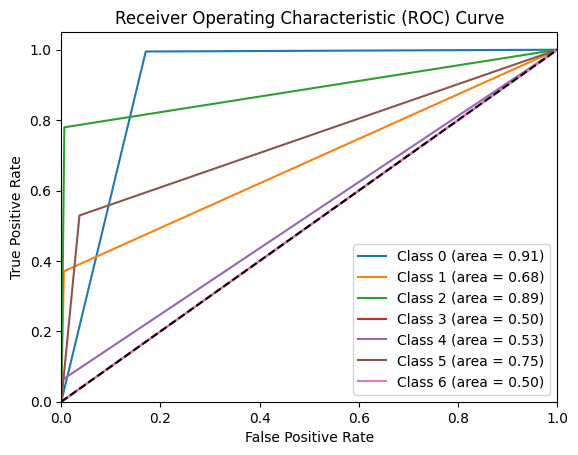

In [55]:
# Step 16: Plot ROC Curve
!pip install scikit-learn matplotlib

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming true_labels_flat and pred_labels_flat are already defined in the "RoBERTa aspect analysis" code

# Binarize the labels for multi-class ROC
true_labels_binarized = label_binarize(true_labels_flat, classes=list(label_map.values()))
pred_labels_binarized = label_binarize(pred_labels_flat, classes=list(label_map.values()))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_map)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], pred_labels_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(len(label_map)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
